In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
df = pd.read_csv("memotion_dataset_7k/labels.csv")
df.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [3]:
meme_text = pd.DataFrame()
meme_text['text'] = df.text_corrected
meme_text['sentiment'] = df.overall_sentiment
meme_text.head()

,text,sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,The best of #10 YearChallenge! Completed in le...,positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [4]:
cleaned = meme_text.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

text         False
sentiment    False
dtype: bool

In [5]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
labels = []
for _, i in target.iterrows():
    labels.append(np.argmax(i))
labels[0:5]

[2, 2, 2, 2, 1]

In [6]:
cleaned.shape,target.shape

((6987, 2), (6987, 3))

C:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

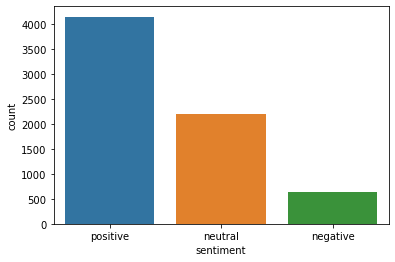

In [7]:
sns.countplot(cleaned.sentiment)

In [8]:
cleaned['sentiment'].value_counts()

positive    4156
neutral     2200
negative     631
Name: sentiment, dtype: int64

In [9]:
import nlpaug
import nlpaug.augmenter.word as naw
def Augmentation(text, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 0
            temps = aug.augment(text.iloc[i],n=6)
        elif np.argmax(labels.iloc[i]) == 1:
            t = 1
            temps = aug.augment(text.iloc[i],n=2)
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append(2)
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences,augmented_sentences_labels

In [10]:
text, sent = Augmentation(cleaned.text, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

C:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

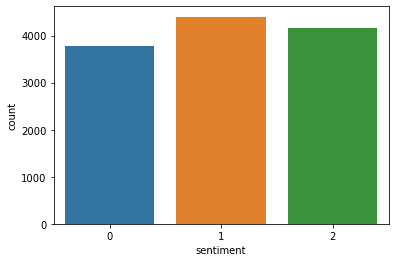

In [12]:
sns.countplot(cleaned.sentiment)

In [11]:
from tensorflow.keras.utils import to_categorical
sent = to_categorical(sent)
pd.DataFrame(text).shape, pd.DataFrame(sent).shape

((12342, 1), (12342, 3))

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(text,sent, test_size = 0.3)
xtest, xval, ytest, yval = train_test_split(xtest,ytest,test_size = 0.4)
xtrain = pd.DataFrame(xtrain)
xtest = pd.DataFrame(xtest)
xval = pd.DataFrame(xval)
ytrain = pd.DataFrame(ytrain)
ytest = pd.DataFrame(ytest)
yval = pd.DataFrame(yval)

In [24]:
xtrain.shape, xtest.shape, xval.shape

((8639, 1), (2221, 1), (1482, 1))

In [26]:
ytrain.value_counts()

0    1    2  
0.0  1.0  0.0    3107
     0.0  1.0    2890
1.0  0.0  0.0    2642
dtype: int64

In [33]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

INFO:absl:Using C:\Users\hp\AppData\Local\Temp\tfhub_modules to cache modules.


In [1]:
# Bert layers
import tensorflow as tf
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(3, activation='softmax', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

<>:9: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:9: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\hp\AppData\Local\Temp\ipykernel_12936\333727184.py:9: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  l = tf.keras.layers.Dense(256(l))


In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [48]:
xtrain = pd.DataFrame(xtrain)
ytrain = pd.DataFrame(ytrain)

In [38]:
X_train=np.asarray(xtrain.astype(np.str))
y_train=np.asarray(ytrain)

In [39]:
X_train.shape,y_train

((8639, 1),
 array([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32))

In [40]:
X_train = np.resize(X_train,(X_train.shape[0], 1))
X_train.shape, y_train.shape

((8639, 1), (8639, 3))

In [41]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [53]:
model.fit(X_train, y_train,validation_data = (xval, yval), epochs=20)

Epoch 1/20
270/270 [==============================] - 247s 916ms/step - loss: 1.0641 - accuracy: 0.4382 - val_loss: 1.0394 - val_accuracy: 0.4534
Epoch 2/20
270/270 [==============================] - 248s 918ms/step - loss: 1.0665 - accuracy: 0.4294 - val_loss: 1.0422 - val_accuracy: 0.4622
Epoch 3/20
270/270 [==============================] - 266s 986ms/step - loss: 1.0618 - accuracy: 0.4335 - val_loss: 1.0563 - val_accuracy: 0.4386
Epoch 4/20
270/270 [==============================] - 320s 1s/step - loss: 1.0630 - accuracy: 0.4285 - val_loss: 1.0806 - val_accuracy: 0.4312
Epoch 5/20
270/270 [==============================] - 331s 1s/step - loss: 1.0670 - accuracy: 0.4325 - val_loss: 1.0478 - val_accuracy: 0.4420
Epoch 6/20
270/270 [==============================] - 331s 1s/step - loss: 1.0640 - accuracy: 0.4376 - val_loss: 1.1131 - val_accuracy: 0.3981
Epoch 7/20
270/270 [==============================] - 330s 1s/step - loss: 1.0583 - accuracy: 0.4325 - val_loss: 1.0583 - val_accurac

In [54]:
X_text, y_test = xtest, ytest
pd.DataFrame(ytest).value_counts()

0    1    2  
0.0  1.0  0.0    791
     0.0  1.0    720
1.0  0.0  0.0    710
dtype: int64

In [55]:
X_test=xtest.astype(np.str)
#y_test=np.asarray(test.sentiment)
#y_test = pd.get_dummies(ytest)

In [56]:
model.evaluate(X_test, ytest)

70/70 [==============================] - 54s 775ms/step - loss: 1.0410 - accuracy: 0.4534


[1.040976881980896, 0.4533993601799011]

In [57]:
y_predicted = model.predict(X_test)

In [58]:
yp = np.argmax(y_predicted, axis = 1)
yt = np.argmax(np.array(ytest), axis = 1)

Text(33.0, 0.5, 'Truth')

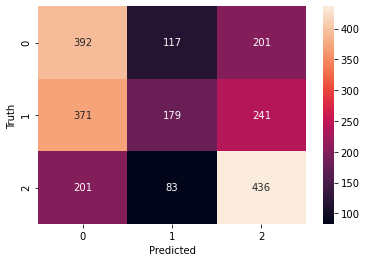

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(yt, yp)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [60]:
print(classification_report(yt, yp))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47       710
           1       0.47      0.23      0.31       791
           2       0.50      0.61      0.55       720

    accuracy                           0.45      2221
   macro avg       0.46      0.46      0.44      2221
weighted avg       0.46      0.45      0.44      2221

